In [5]:
##  LIBRERIAS  
import os
import numpy as np
import pandas as pd
import re
from unidecode import unidecode
from tqdm.notebook import trange, tqdm
import time
import math

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon

from mpl_toolkits import mplot3d
%matplotlib inline

pd.set_option('display.max_columns', 50)

In [6]:
## LECTURA ... Df Parametros
par_file_name="CLAG1.par"

#print(open(par_file_name, "r").read())
open(par_file_name, "r").close()
l=[re.split("[']", x) for x in open(par_file_name, "r")]
#print(x)
open(par_file_name, "r").close()            #cerrar archivo 
## diccionario de parámetros
param={}
param_l=[]
paran_v=[]

## OJO!! 
# Separador no es el mismo en todos los SO -->  Usar OS

## header:          PARÁMETRO 1
param[1]=l[0][0].strip()
param_l.append(l[0][1].strip().replace(os.sep,""))
## input file:          PARÁMETRO 2
param[2]=l[1][0].strip().rsplit(os.sep, 1)[-1]
param_l.append(l[1][1].strip().replace(os.sep,""))
## columns for data:          PARÁMETRO 3
param[3]=[int(x) for x in l[2][0].strip().split(",")]
param_l.append(l[2][1].strip().replace(os.sep,"")[0:16])
## initial search volume:          PARÁMETRO 4
param[4]=[float(x) for x in l[3][0].strip().split(",")]
param_l.append(l[3][1].strip().replace(os.sep,""))
## Number of Risk Thresholds:          PARÁMETRO 5
param[5]=[int(x) for x in l[4][0].strip().split(",")]
param_l.append(l[4][1].strip().replace(os.sep,"")[0:37])
## Selected risk thresholds:          PARÁMETRO 6
param[6]=[float(x) for x in l[5][0].strip().split(",")]
param_l.append(l[5][1].strip().replace(os.sep,""))
## Number of data in local volume:          PARÁMETRO 7
param[7]=[int(x) for x in l[6][0].strip().split(",")]
param_l.append(l[6][1].strip().replace(os.sep,""))
## Number of units:          PARÁMETRO 8
param[8]=[int(x) for x in l[7][0].strip().split(",")]
param_l.append(l[7][1].strip().replace(os.sep,""))
## Unit names:          PARÁMETRO 9
param[9]=[int(x) for x in l[8][0].strip().split(",")]
param_l.append(l[8][1].strip().replace(os.sep,""))
## not consider values less than:          PARÁMETRO 10
param[10]=[int(x) for x in l[9][0].strip().split(",")]
param_l.append(l[9][1].strip().replace(os.sep,""))
## output files name:          PARÁMETRO 11
param[11]=l[10][0].strip().rsplit(os.sep, 1)[-1]
param_l.append(l[10][1].strip().replace(os.sep,""))
## number of zones:          PARÁMETRO 12
param[12]=[int(x) for x in l[11][0].strip().split(",")]
param_l.append(l[11][1].strip().replace(os.sep,""))
## zone identifiers:          PARÁMETRO 13
param[13]=[int(x) for x in l[12][0].strip().split(",")]
param_l.append(l[12][1].strip().replace(os.sep,""))
## azimuth of search orientation per zone :          PARÁMETRO 14
param[14]=[int(x) for x in l[13][0].strip().split(",")]
param_l.append(l[13][1].strip().replace(os.sep,""))
## Anisotropy ratios:          PARÁMETRO 15
param[15]=[float(x) for x in l[14][0].strip().split(",")]
param_l.append(l[14][1].strip().replace(os.sep,""))
## Exclude data from the same drillhole:          PARÁMETRO 16
param[16]=[int(x) for x in l[15][0].strip().split(",")]
param_l.append(l[15][1].strip().replace(os.sep,""))
## Option to weight data by search expansion:          PARÁMETRO 17
param[17]=[int(x) for x in l[16][0].strip().split(",")]
param_l.append(l[16][1].strip().replace(os.sep,""))

df_parametros = pd.DataFrame(list(zip(list(range(1,18)), param_l, list(param.values()))),
                            columns=['Orden','Descripcion', 'Valor']
                        )


df_parametros






,Orden,Descripcion,Valor
0,1,header,Capping Test Copper Using BHID
1,2,input file,CLAG_MR2022_2.csv
2,3,columns for data,"[1, 2, 3, 4, 6, 5, 7, 8]"
3,4,initial search volume,"[30.0, 30.0, 30.0]"
4,5,Number of Risk Thresholds to consider,[6]
5,6,selected risk thresholds,"[0.1, 0.125, 0.15, 0.175, 0.2, 0.225]"
6,7,number of data in local volume,[21]
7,8,number of units,[2]
8,9,unit names,"[31, 32]"
9,10,do not consider values less than,[0]


In [7]:
##   Lectura CSV compositos .. validar si hay nulos o no

df_CLAG_MR_2022 = pd.read_csv(param[2])
df_CLAG_MR_2022.head(2)
## Requerimiento: No NaN ni missing values
'''
Algoritmo localcapping no admite valores nulos ni missings
función missing_val(df) identifica casos missing y nulos
'''

def missing_val(df):
    cero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mz_table = pd.concat([cero_val, mis_val], axis=1)
    mz_table = mz_table.rename(
               columns = {0 : 'Valores  Cero', 1 : 'Valores Missing'})
    mz_table['Total Cero + Missing'] = mz_table['Valores  Cero'] + mz_table['Valores Missing']
    mz_table = mz_table[mz_table.iloc[:,1] != 0].round(1)
    print ("Df Columnas: " + str(df.shape[1]) + " Df Filas: " + str(df.shape[0]) + " \n"      
            "Columnas con Ceros / Missing: " + str(mz_table.shape[0]))
    return mz_table

## 
missing_val(df_CLAG_MR_2022)  




Df Columnas: 8 Df Filas: 4255 
Columnas con Ceros / Missing: 0


,Valores Cero,Valores Missing,Total Cero + Missing


In [8]:
df_CLAG_MR_2022.head(2)

,COUNT,mid_x,mid_y,mid_z,Ag_ppm_BESTEL,NBKRT,AG_SUBZONAS,HOLEID
0,2336,4072.2950,4850.2450,4199.8669,25.146513,32,42,A019
1,2337,4073.5668,4848.7522,4196.7885,40.000000,31,42,A019


In [9]:
# ACONDICIONAR DATAFRAME


'''
Este ordenamiento no limita la seleccion decolumnas por nombre
Hace seleccion en funcion del orden inicial de columnas
'''
df_CLAG_MR_2022_R=df_CLAG_MR_2022[[df_CLAG_MR_2022.iloc[:,0].name,
                                   df_CLAG_MR_2022.iloc[:,1].name,
                                   df_CLAG_MR_2022.iloc[:,2].name,
                                   df_CLAG_MR_2022.iloc[:,3].name,
                                   df_CLAG_MR_2022.iloc[:,4].name,
                                   df_CLAG_MR_2022.iloc[:,5].name,
                                   df_CLAG_MR_2022.iloc[:,6].name,
                                   df_CLAG_MR_2022.iloc[:,7].name]]

df_CLAG_MR_2022=df_CLAG_MR_2022_R

df_CLAG_MR_2022.head(2)


##  $$$  INICILIZAR VALORES PARA 6 UMBRALES
##  y    #ID,BHID,X,Y,Z,CODE,ZONE,VALUE,CAPVAL1,CAPPED1,CAPVAL2,CAPPED2,CAPVAL3,CAPPED3,CAPVAL4,CAPPED4,CAPVAL5,CAPPED5,CAPVAL6,CAPPED6
#         ,AvgSin,PROP_12,Num_Data

df_CLAG_MR_2022["CAPVAL1_PY"]=df_CLAG_MR_2022.iloc[:,4]
df_CLAG_MR_2022["CAPPED1_PY"]=0
df_CLAG_MR_2022["CAPVAL2_PY"]=df_CLAG_MR_2022.iloc[:,4]
df_CLAG_MR_2022["CAPPED2_PY"]=0
df_CLAG_MR_2022["CAPVAL3_PY"]=df_CLAG_MR_2022.iloc[:,4]
df_CLAG_MR_2022["CAPPED3_PY"]=0
df_CLAG_MR_2022["CAPVAL4_PY"]=df_CLAG_MR_2022.iloc[:,4]
df_CLAG_MR_2022["CAPPED4_PY"]=0
df_CLAG_MR_2022["CAPVAL5_PY"]=df_CLAG_MR_2022.iloc[:,4]
df_CLAG_MR_2022["CAPPED5_PY"]=0
df_CLAG_MR_2022["CAPVAL6_PY"]=df_CLAG_MR_2022.iloc[:,4]
df_CLAG_MR_2022["CAPPED6_PY"]=0

df_CLAG_MR_2022["AvgSin_PY"]=0

df_CLAG_MR_2022["AvgCon_PY"]=0           ##  PROMEDIO CON COMPOSITO

df_CLAG_MR_2022["PROP_12_PY"]=0          ## PROPORCION APORTADA POR COMPOSITO   incluido composito
df_CLAG_MR_2022["PROP_SIN_12_PY"]=0          ## PROPORCION APORTADA POR COMPOSITO         excluido composito 

df_CLAG_MR_2022["Num_Data_PY"]=0


df_CLAG_MR_2022["Num_EXPAN_PY"]=0          ## CANTIDAD DE EXPANSIONES GEENRADAS EN ESE COMPOSITO

df_CLAG_MR_2022["EVALUADO_PY"]=0       ## DUMMY  1= SI ENTRO A CALCULO PYTHON

df_CLAG_MR_2022["AL1_PY"]=0       ## DUMMY  1= SI ENTRO A CALCULO PYTHON
df_CLAG_MR_2022["AL2_PY"]=0       ## DUMMY  1= SI ENTRO A CALCULO PYTHON


# df_CLAG_MR_2022["List_LEY_PY"]=0          ## LEY DE CADA COMPOSITO QUE INTERVIENE 21
# df_CLAG_MR_2022["List_INDEX_PY"]=0                ## INDICES DE COMPOSITOS 21
# df_CLAG_MR_2022["List_COUNT_INDEX_PY"]=0         ## INDICE COMPOSITO

# df_CLAG_MR_2022["List_INDEX_BUBBLE_PY"]=0         ## INDICE TODOS LOS COMPOSITOS     NO  top 21  -  TODOS          LISTA
# df_CLAG_MR_2022["TIME_PY"]=0            ## segundos por composito CALCULO


df_CLAG_MR_2022_ORIG=df_CLAG_MR_2022

df_CLAG_MR_2022.head(2)






,COUNT,mid_x,mid_y,mid_z,Ag_ppm_BESTEL,NBKRT,AG_SUBZONAS,HOLEID,CAPVAL1_PY,CAPPED1_PY,CAPVAL2_PY,CAPPED2_PY,CAPVAL3_PY,CAPPED3_PY,CAPVAL4_PY,CAPPED4_PY,CAPVAL5_PY,CAPPED5_PY,CAPVAL6_PY,CAPPED6_PY,AvgSin_PY,AvgCon_PY,PROP_12_PY,PROP_SIN_12_PY,Num_Data_PY,Num_EXPAN_PY,EVALUADO_PY,AL1_PY,AL2_PY
0,2336,4072.2950,4850.2450,4199.8669,25.146513,32,42,A019,25.146513,0,25.146513,0,25.146513,0,25.146513,0,25.146513,0,25.146513,0,0,0,0,0,0,0,0,0,0
1,2337,4073.5668,4848.7522,4196.7885,40.000000,31,42,A019,40.000000,0,40.000000,0,40.000000,0,40.000000,0,40.000000,0,40.000000,0,0,0,0,0,0,0,0,0,0


In [10]:
df_CLAG_MR_2022.shape

(4255, 29)

In [11]:
df_parametros.Valor[14]

[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]

In [12]:


parametro_expansion=0.25
expansiones_max=12
expansiones_realizadas=0
round_hemi_accuracy=2

max_compositos_interiores=19  # ( restar 1 al numero objetivo)

freno_1_composito_x_roca=0  ###  SOLO LEER UN SOLO COMPOSITO POR COMBINACION ROCA/ZONA
freno_2_roca_x_zona=0  ###  SOLO LEER UNA SOLA ROCA POR ZONA
freno_3_zona=0    ### SOLO LEER UNICA ZONA

iterador=0      ##  PARA SIGNAR RATIO x ZONA

composito_counts=0

flag_holeid=df_parametros.Valor[15][0]

#for zone in df_parametros.Valor[12][:1]:     ## borrar   [:2]
zonas = df_parametros.Valor[12]
for zone in zonas:     #################################  FIJO PARA PRUEBA  BORRAR
    
    print("\n\n")
    print("zone:",zone)
    print(" ") 
    #  df_parametros.Valor[13]         ## LISTA DE AZIMUTH
    print("azimuth:",df_parametros.Valor[13][iterador])
    azimuth=df_parametros.Valor[13][iterador]
    cartesiana=0          ## <------ 

    if azimuth < 90:
        cartesiana=90-azimuth 
    elif azimuth < 180:
        cartesiana=360-(azimuth-90) 
    elif azimuth < 270:
        cartesiana=270-(azimuth-180) 
    elif azimuth < 360:
        cartesiana=180-(azimuth-270) 
        
    print("cartesiana:",cartesiana)
    rad=math.radians(cartesiana)    ## <------  APLICAR ACA SIN COS etc etc    
    print("radian:",rad)
    #df_parametros.Valor[14]                            ## LISTA DE ANISOTROPIA 
    print("ratio anisotropia:",df_parametros.Valor[14][iterador])

    ratio=df_parametros.Valor[14][iterador]
    hemi_axis_x, hemi_axis_y, hemi_axis_z = [], [], []
    for i in range(expansiones_max):       #  30*30*30       30*75*30
        # print((df_parametros.Valor[3][0] / 2)*((1+parametro_expansion)**i))
        # print(((df_parametros.Valor[3][1]*ratio) / 2)*((1+parametro_expansion)**i))
        # print((df_parametros.Valor[3][2] / 2)*((1+parametro_expansion)**i))
        # print((df_parametros.Valor[3][0] / 2)*((1+parametro_expansion)**i)*2)
        # print(((df_parametros.Valor[3][1]*ratio) / 2)*((1+parametro_expansion)**i)*2)
        # print((df_parametros.Valor[3][2] / 2)*((1+parametro_expansion)**i)*2)
        semi_x=(df_parametros.Valor[3][0] / 2)*((1+parametro_expansion)**i)
        semi_y=((df_parametros.Valor[3][1]*ratio) / 2)*((1+parametro_expansion)**i)
        semi_z=(df_parametros.Valor[3][2] / 2)*((1+parametro_expansion)**i)
        hemi_axis_x.append(round(semi_x,round_hemi_accuracy))
        hemi_axis_y.append(round(semi_y,round_hemi_accuracy))
        hemi_axis_z.append(round(semi_z,round_hemi_accuracy))

    ###for rock in df_parametros.Valor[8][:1]:## borrar   [3]
    rocks=df_parametros.Valor[8]
    for rock in rocks:

        freno_1_composito_x_roca=0

        print("\n\n\n")
        print("    rock:",rock)
        print("    zone:",zone)
        print(" ")
        print("    parametros de la Roca ")
        print("    ratio anisotropia:",ratio)
        print("    azimuth: ",azimuth)
        print("    cartesiana: ",cartesiana)
        print("    radian: ",rad)

        df_zona_roca_local=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)]        


        for obs in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T:  ## ITERAR INDICES
        #for obs in df_zona_roca_local.index:
        #for i in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T:   

            composito_counts=composito_counts+1

            print("\n")
            print("        index composito :",obs)
            print(" ")
            x=df_zona_roca_local.iloc[:,1][obs]
            y=df_zona_roca_local.iloc[:,2][obs]
            z=df_zona_roca_local.iloc[:,3][obs]
             
            print("        x: ",x)
            print("        y: ",y)
            print("        z: ",z)
            obs_holeid=df_zona_roca_local.T[obs][7]
            print(" ")
            print("        holeid: ",obs_holeid)
            # x_SI,y_SI= x - semi_x,y + semi_y        
            # x_II,y_II= x - semi_x,y - semi_y
            # x_SD,y_SD= x + semi_x,y + semi_y
            # x_ID,y_ID= x + semi_x,y - semi_y      
            # print("        SI:",x_SI,y_SI)
            # print("        II:",x_II,y_II)  
            # print("        SD:",x_SD,y_SD) 
            # print("        ID:",x_ID,y_ID)
            # s = gpd.GeoSeries([Polygon([(x_II,y_II), (x_SI, y_SI), (x_SD, y_SD), (x_ID, y_ID)])])      
            ## RESPETAR ORDEN II SI SD ID
            #s[0]
            #s.rotate(cartesiana, origin=(x,y))[0]
            # rx,ry = s.rotate(  cartesiana, origin=(x,y))[0].exterior.coords.xy
            # coords = np.dstack((rx,ry)).tolist()
            #print(coords)           
            # print("        Rotated coords: ")
            # print("        ",coords[0][0][0],coords[0][0][1])
            # print("        ",coords[0][1][0],coords[0][1][1])
            # print("        ",coords[0][2][0],coords[0][2][1])
            # print("        ",coords[0][3][0],coords[0][3][1])
            # print("        ",coords[0][4][0],coords[0][4][1])
            # rotado2d=s.rotate(cartesiana, origin=(x,y))[0]
            # index_inner_3d=[]## INDICES EN POLIGONO ROTADO 3D  
            index_inner_3d=[]## INDICES EN POLIGONO ROTADO 3D
            ley=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,4][obs]
            print("        ley composito : ",ley)

            for i in range(expansiones_max):
                print(" ")
                print(" ")
                print("            expansion: ",i)
                print(" ")
                '''
                print("            semi eje x:",hemi_axis_x[i])
                print("            semi eje y:",hemi_axis_y[i])
                print("            semi eje z:",hemi_axis_z[i])
                '''

                x_SI,y_SI= x - hemi_axis_x[i] , y + hemi_axis_y[i]       
                x_II,y_II= x - hemi_axis_x[i] , y - hemi_axis_y[i]
                x_SD,y_SD= x + hemi_axis_x[i] , y + hemi_axis_y[i]
                x_ID,y_ID= x + hemi_axis_x[i] , y - hemi_axis_y[i]  

                '''
                print("            SI:  x: ",x_SI,"  y:",y_SI)
                print("            II:  x: ",x_II,"  y:",y_II)  
                print("            SD:  x: ",x_SD,"  y:",y_SD) 
                print("            ID:  x: ",x_ID,"  y:",y_ID)
                '''

                s = gpd.GeoSeries([Polygon([(x_II,y_II), (x_SI, y_SI), (x_SD, y_SD), (x_ID, y_ID)])])      
                # RESPETAR ORDEN II SI SD ID
                #s[0]
                #s.rotate(cartesiana, origin=(x,y))[0]
                #rx,ry = s.rotate(  cartesiana, origin=(x,y))[0].exterior.coords.xy
                rotado2d=s.rotate(cartesiana, origin=(x,y))[0]
                rx,ry = rotado2d.exterior.coords.xy
                coords = np.dstack((rx,ry)).tolist()
                '''
                print("            Rotated coords: ")
                print("            x: ",coords[0][0][0]," y: ",coords[0][0][1])
                print("            x: ",coords[0][1][0]," y: ",coords[0][1][1])
                print("            x: ",coords[0][2][0]," y: ",coords[0][2][1])
                print("            x: ",coords[0][3][0]," y: ",coords[0][3][1])
                print("            x: ",coords[0][4][0]," y: ",coords[0][4][1])
                '''


                for obs_sub in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T:

                    '''
                    print(" ")
                    print("                obs    : ",obs)
                    print("                obs_sub: ",obs_sub)
                    '''
                    sub_ley=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,4][obs_sub]
                    '''
                    print("                ley_sub: ",sub_ley)   
                    ''' 

                    x_int=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs_sub][1]
                    y_int=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs_sub][2]
                    '''
                    print("                x_sub: ",x_int)
                    print("                y_sub: ",y_int)
                    '''

                    composito_inter= gpd.GeoSeries([Point(x_int,y_int)])  ##  COMPONER coords del subcomposito

                    if rotado2d.intersects(composito_inter[0]) == True:
                        '''
                        print("                    SI 2D")
                        '''

                        z_int=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs_sub][3]
                        '''
                        print("                    z_sub: ",z_int)
                        print("                    z:     ",z)
                        '''
                        z_inner_diff=abs(z-z_int)
                        '''
                        print("                    dist z:",z_inner_diff)
                        print("                    dist max z:",hemi_axis_z[i])
                        '''

                        if z_inner_diff <= hemi_axis_z[i]:
                            '''
                            print("                        SI 3D")
                            '''
                            #index_inner_3d.append(obs_sub)
                            #print("                        index_inner_3d: ",index_inner_3d)

                            subobs_holeid=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs_sub][7]

                            '''
                            print("                        drillhole obs    : ",obs_holeid)
                            print("                        drillhole obs sub: ",subobs_holeid)
                            '''

                            if obs_sub not in index_inner_3d:
                                if flag_holeid==1:
                                    '''
                                    print("                            SI FLAG EXCLUIR SAME ID")
                                    '''
                                    if obs_holeid!=subobs_holeid:
                                        '''
                                        print("                            DISTINTO ID  -->  APPEND") 
                                        '''
                                        index_inner_3d.append(obs_sub)
                                else:
                                    index_inner_3d.append(obs_sub)

                    '''
                    else:
                        print("                    NO 2D") 
                    '''

                    if len(index_inner_3d) > max_compositos_interiores:       ####  ROMPER APENAS ENCUENTRE 20
                        break

                print("            ",index_inner_3d)
                print("            longitud index_inner:   ",len(index_inner_3d))
                #print("# expansion sub compositos:   ",i)
                ## NECESARIO ROMPER A ESTE NIVEL 
                if len(index_inner_3d) > max_compositos_interiores:   ###  ROMPER EXPANSION
                    print("# expansion break bucles expansivos:   ",i)
                    break   ###  ROMPER EXPANSION

                # if i > 8:   ###  ROMPER EXPANSION por numero de expansiones
                #     break   ###  ROMPER EXPANSION
            print(" ")
            print("verificar lista de busqueda...")
            print("longitud inder_inner fuera del bucle    ",len(index_inner_3d))
 
            print("indice composito en evaluacion -- NO SUB--   ",obs)
            index_inner_3d.append(obs)
            print("lista final de compositos SUB asociados a composito en evaluacion + composito en evaluacion")
            print(index_inner_3d)
            print("longitud final index  ",len(index_inner_3d))


            print(" ")
            print(" ")

            '''
            print("Dataframe solo inner index")
            print(df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[index_inner_3d])
            '''
            print("solo leyes")
            print(df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[index_inner_3d].iloc[[4]])
            print("\n")

            sub_df=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[index_inner_3d].iloc[[4]].T
            print("\n")        
            #print(sub_df)
            print("\n")

            sub_df["percent_ley"] = (sub_df.iloc[:,0] / sub_df.iloc[:,0].sum()) 
            print("\n")
            print(sub_df)
            print("\n")
            print("  Umbrales",df_parametros.Valor[5])
            print("\n")
            print("ley promedio")
            print(sub_df.iloc[:,0].mean())
            print("\n")
            print("relativo aportado por el composito ",sub_df.iloc[-1,1]*100,"%")  ## procentaje del composito
            print(" ")
            print(" ")      

            df_CLAG_MR_2022.iloc[obs,22]=len(index_inner_3d)
            df_CLAG_MR_2022.iloc[obs,20]=sub_df.iloc[:,0].mean()
            df_CLAG_MR_2022.iloc[obs,23]=i
            df_CLAG_MR_2022.iloc[obs,21]=sub_df.iloc[-1,1]
            df_CLAG_MR_2022.iloc[obs,24]=1                 #### DUMMY 

            '''
            df_CLAG_MR_2022["AvgSin_PY"]=0
            df_CLAG_MR_2022["AvgCon_PY"]=0           ##  PROMEDIO CON COMPOSITO
            df_CLAG_MR_2022["PROP_12_PY"]=0          ## PROPORCION APORTADA POR COMPOSITO   incluido composito
            df_CLAG_MR_2022["PROP_SIN_12_PY"]=0          ## PROPORCION APORTADA POR COMPOSITO         excluido composito 
            df_CLAG_MR_2022["Num_Data_PY"]=0
            df_CLAG_MR_2022["Num_EXPAN_PY"]=0          ## CANTIDAD DE EXPANSIONES GEENRADAS EN ESE COMPOSITO
            df_CLAG_MR_2022["EVALUADO_PY"]=0       ## DUMMY  1= SI ENTRO A CALCULO PYTHON
            df_CLAG_MR_2022["List_LEY_PY"]=0          ## LEY DE CADA COMPOSITO QUE INTERVIENE 21
            df_CLAG_MR_2022["List_INDEX_PY"]=0                ## INDICES DE COMPOSITOS 21
            df_CLAG_MR_2022["List_COUNT_INDEX_PY"]=0         ## INDICE COMPOSITO
            df_CLAG_MR_2022["List_INDEX_BUBBLE_PY"]=0         ## INDICE TODOS LOS COMPOSITOS     NO  top 21  -  TODOS          LISTA
            df_CLAG_MR_2022["TIME_PY"]=0  
            '''

            print("pre_bucle")
            
            ley_sin=sub_df.iloc[:-1,1].mean()      ### promedio SIN composito central
            ley_con=sub_df.iloc[:,1].mean()        ### promedio CON composito central
            variax=abs((ley_con/ley_sin)-1)

            if variax > df_parametros.Valor[5][0]:
                print("T1")
                print(df_parametros.Valor[5][0])
                df_CLAG_MR_2022.iloc[obs,8]=ley-(sub_df.iloc[:,0].mean()*df_parametros.Valor[5][0])
                df_CLAG_MR_2022.iloc[obs,9]=1             
                if variax > df_parametros.Valor[5][1]:
                    print("T2")
                    print(df_parametros.Valor[5][1])
                    df_CLAG_MR_2022.iloc[obs,10]=ley-(sub_df.iloc[:,0].mean()*df_parametros.Valor[5][1])
                    df_CLAG_MR_2022.iloc[obs,11]=1         
                    if variax> df_parametros.Valor[5][2]:
                        print("T3")
                        print(df_parametros.Valor[5][2])
                        df_CLAG_MR_2022.iloc[obs,12]=ley-(sub_df.iloc[:,0].mean()*df_parametros.Valor[5][2])
                        df_CLAG_MR_2022.iloc[obs,13]=1
                        if variax > df_parametros.Valor[5][3]:
                            print("T4")
                            print(df_parametros.Valor[5][3])
                            df_CLAG_MR_2022.iloc[obs,14]=ley-(sub_df.iloc[:,0].mean()*df_parametros.Valor[5][3])
                            df_CLAG_MR_2022.iloc[obs,15]=1
                            if variax > df_parametros.Valor[5][4]:
                                print("T5")
                                print(df_parametros.Valor[5][4])
                                df_CLAG_MR_2022.iloc[obs,16]=ley-(sub_df.iloc[:,0].mean()*df_parametros.Valor[5][4])
                                df_CLAG_MR_2022.iloc[obs,17]=1
                                if variax > df_parametros.Valor[5][5]:
                                    print("T6")
                                    print(df_parametros.Valor[5][5])
                                    df_CLAG_MR_2022.iloc[obs,18]=ley-(sub_df.iloc[:,0].mean()*df_parametros.Valor[5][5])
                                    df_CLAG_MR_2022.iloc[obs,19]=1               
            else:
                print("NO EN UMBRAL MINIMO")


            
            freno_1_composito_x_roca=freno_1_composito_x_roca+1
            if freno_1_composito_x_roca>0:
                break
        freno_2_roca_x_zona=freno_2_roca_x_zona+1
        if freno_2_roca_x_zona>0:
            break
    freno_3_zona=freno_3_zona+1
    if freno_3_zona>0:
        break
    iterador=iterador+1


    print(" ")
    print(" ")



#df_CLAG_MR_2022.to_csv("Local_ag_martes_test.csv")






zone: 41
 
azimuth: 140
cartesiana: 310
radian: 5.410520681182422
ratio anisotropia: 2.5




    rock: 31
    zone: 41
 
    parametros de la Roca 
    ratio anisotropia: 2.5
    azimuth:  140
    cartesiana:  310
    radian:  5.410520681182422


        index composito : 73
 
        x:  3185.3567
        y:  4329.8712
        z:  4116.0064
 
        holeid:  A055
        ley composito :  0.828571
 
 
            expansion:  0
 
             []
            longitud index_inner:    0
 
 
            expansion:  1
 
             []
            longitud index_inner:    0
 
 
            expansion:  2
 
             []
            longitud index_inner:    0
 
 
            expansion:  3
 
             []
            longitud index_inner:    0
 
 
            expansion:  4
 
             [377, 378]
            longitud index_inner:    2
 
 
            expansion:  5
 
             [377, 378]
            longitud index_inner:    2
 
 
            expansion:  6
 
             [377, 378, 3

In [94]:
df_CLAG_MR_2022.to_csv("c_test.csv")


In [16]:
df_CLAG_MR_2022

,COUNT,mid_x,mid_y,mid_z,Ag_ppm_BESTEL,NBKRT,AG_SUBZONAS,HOLEID,CAPVAL1_PY,CAPPED1_PY,CAPVAL2_PY,CAPPED2_PY,CAPVAL3_PY,CAPPED3_PY,CAPVAL4_PY,CAPPED4_PY,CAPVAL5_PY,CAPPED5_PY,CAPVAL6_PY,CAPPED6_PY,AvgSin_PY,AvgCon_PY,PROP_12_PY,PROP_SIN_12_PY,Num_Data_PY,Num_EXPAN_PY,EVALUADO_PY,AL1_PY,AL2_PY
0,2336,4072.2950,4850.2450,4199.8669,25.146513,32,42,A019,25.146513,0,25.146513,0,25.146513,0,25.146513,0,25.146513,0,25.146513,0,0.0,0.0,0,0,0,0,0,0,0
1,2337,4073.5668,4848.7522,4196.7885,40.000000,31,42,A019,40.000000,0,40.000000,0,40.000000,0,40.000000,0,40.000000,0,40.000000,0,0.0,0.0,0,0,0,0,0,0,0
2,2338,4074.6121,4847.5252,4194.2584,35.799999,31,42,A019,35.799999,0,35.799999,0,35.799999,0,35.799999,0,35.799999,0,35.799999,0,0.0,0.0,0,0,0,0,0,0,0
3,2339,4075.6575,4846.2982,4191.7282,44.693333,31,42,A019,44.693333,0,44.693333,0,44.693333,0,44.693333,0,44.693333,0,44.693333,0,0.0,0.0,0,0,0,0,0,0,0
4,2340,4076.7028,4845.0713,4189.1980,45.193333,31,42,A019,45.193333,0,45.193333,0,45.193333,0,45.193333,0,45.193333,0,45.193333,0,0.0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,390969,4234.5329,5190.9378,4185.3258,7.000000,31,42,A913,7.000000,0,7.000000,0,7.000000,0,7.000000,0,7.000000,0,7.000000,0,0.0,0.0,0,0,0,0,0,0,0
4251,390970,4234.9222,5190.5647,4181.7917,7.457831,31,42,A913,7.457831,0,7.457831,0,7.457831,0,7.457831,0,7.457831,0,7.457831,0,0.0,0.0,0,0,0,0,0,0,0
4252,390971,4235.3126,5190.1954,4178.2573,8.333333,31,42,A913,8.333333,0,8.333333,0,8.333333,0,8.333333,0,8.333333,0,8.333333,0,0.0,0.0,0,0,0,0,0,0,0
4253,394849,3690.3063,4739.9698,4152.7452,122.400002,32,41,A951,122.400002,0,122.400002,0,122.400002,0,122.400002,0,122.400002,0,122.400002,0,0.0,0.0,0,0,0,0,0,0,0


In [17]:
df_CLAG_MR_2022[df_CLAG_MR_2022.EVALUADO_PY==1]

,COUNT,mid_x,mid_y,mid_z,Ag_ppm_BESTEL,NBKRT,AG_SUBZONAS,HOLEID,CAPVAL1_PY,CAPPED1_PY,CAPVAL2_PY,CAPPED2_PY,CAPVAL3_PY,CAPPED3_PY,CAPVAL4_PY,CAPPED4_PY,CAPVAL5_PY,CAPPED5_PY,CAPVAL6_PY,CAPPED6_PY,AvgSin_PY,AvgCon_PY,PROP_12_PY,PROP_SIN_12_PY,Num_Data_PY,Num_EXPAN_PY,EVALUADO_PY,AL1_PY,AL2_PY


In [15]:
df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs]

COUNT                  6586
mid_x             3185.3567
mid_y             4329.8712
mid_z             4116.0064
Ag_ppm_BESTEL      0.828571
NBKRT                    31
AG_SUBZONAS              41
HOLEID                 A055
CAPVAL1_PY         0.828571
CAPPED1_PY                0
CAPVAL2_PY         0.828571
CAPPED2_PY                0
CAPVAL3_PY         0.828571
CAPPED3_PY                0
CAPVAL4_PY         0.828571
CAPPED4_PY                0
CAPVAL5_PY         0.828571
CAPPED5_PY                0
CAPVAL6_PY         0.828571
CAPPED6_PY                0
AvgSin_PY         14.745175
AvgCon_PY          0.002676
PROP_12_PY               21
PROP_SIN_12_PY            8
Num_Data_PY               1
Num_EXPAN_PY              0
EVALUADO_PY               0
AL1_PY                    0
AL2_PY                    0
Name: 73, dtype: object

In [51]:
df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[obs]

COUNT                       13058
mid_x                   3705.1734
mid_y                   4835.3377
mid_z                    4188.079
Ag_ppm_BESTEL           45.349998
NBKRT                          31
AG_SUBZONAS                    41
HOLEID                      A1015
CAPVAL1_PY              45.349998
CAPPED1_PY                      0
CAPVAL2_PY              45.349998
CAPPED2_PY                      0
CAPVAL3_PY              45.349998
CAPPED3_PY                      0
CAPVAL4_PY              45.349998
CAPPED4_PY                      0
CAPVAL5_PY              45.349998
CAPPED5_PY                      0
CAPVAL6_PY              45.349998
CAPPED6_PY                      0
AvgSin_PY                     0.0
AvgCon_PY                     0.0
PROP_12_PY                      0
PROP_SIN_12_PY                  0
Num_Data_PY                     0
Num_EXPAN_PY                    0
EVALUADO_PY                     0
List_LEY_PY                     0
List_INDEX_PY                   0
List_COUNT_IND

In [80]:
obs_holeid=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs][7]
obs_holeid

'A055'

In [81]:
obs_holeid=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[obs,7]
obs_holeid

'A1015'

In [21]:
obs_holeid=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs][7]
obs_holeid

501

In [28]:
composito_counts

1

In [21]:
df_CLAG_MR_2022

,COUNT,mid_x,mid_y,mid_z,Ag_ppm_BESTEL,NBKRT,AG_SUBZONAS,HOLEID,CAPVAL1_PY,CAPPED1_PY,CAPVAL2_PY,CAPPED2_PY,CAPVAL3_PY,CAPPED3_PY,CAPVAL4_PY,CAPPED4_PY,CAPVAL5_PY,CAPPED5_PY,CAPVAL6_PY,CAPPED6_PY,AvgSin_PY,AvgCon_PY,PROP_12_PY,PROP_SIN_12_PY,Num_Data_PY,Num_EXPAN_PY,EVALUADO_PY,List_LEY_PY,List_INDEX_PY,List_COUNT_INDEX_PY,List_INDEX_BUBBLE_PY,TIME_PY
0,2336,4072.2950,4850.2450,4199.8669,25.146513,32,42,A019,25.146513,0,25.146513,0,25.146513,0,25.146513,0,25.146513,0,25.146513,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
1,2337,4073.5668,4848.7522,4196.7885,40.000000,31,42,A019,40.000000,0,40.000000,0,40.000000,0,40.000000,0,40.000000,0,40.000000,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
2,2338,4074.6121,4847.5252,4194.2584,35.799999,31,42,A019,35.799999,0,35.799999,0,35.799999,0,35.799999,0,35.799999,0,35.799999,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
3,2339,4075.6575,4846.2982,4191.7282,44.693333,31,42,A019,44.693333,0,44.693333,0,44.693333,0,44.693333,0,44.693333,0,44.693333,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
4,2340,4076.7028,4845.0713,4189.1980,45.193333,31,42,A019,45.193333,0,45.193333,0,45.193333,0,45.193333,0,45.193333,0,45.193333,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,390969,4234.5329,5190.9378,4185.3258,7.000000,31,42,A913,7.000000,0,7.000000,0,7.000000,0,7.000000,0,7.000000,0,7.000000,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
4251,390970,4234.9222,5190.5647,4181.7917,7.457831,31,42,A913,7.457831,0,7.457831,0,7.457831,0,7.457831,0,7.457831,0,7.457831,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
4252,390971,4235.3126,5190.1954,4178.2573,8.333333,31,42,A913,8.333333,0,8.333333,0,8.333333,0,8.333333,0,8.333333,0,8.333333,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0
4253,394849,3690.3063,4739.9698,4152.7452,122.400002,32,41,A951,122.400002,0,122.400002,0,122.400002,0,122.400002,0,122.400002,0,122.400002,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0


In [22]:
df_CLAG_MR_2022.T[73]

COUNT                 6586
mid_x            3185.3567
mid_y            4329.8712
mid_z            4116.0064
Ag_ppm_BESTEL     0.828571
NBKRT                   31
AG_SUBZONAS             41
HOLEID                A055
CAPVAL1_PY        0.828571
CAPPED1_PY               0
CAPVAL2_PY        0.828571
CAPPED2_PY               0
CAPVAL3_PY        0.828571
CAPPED3_PY               0
CAPVAL4_PY        0.828571
CAPPED4_PY               0
CAPVAL5_PY        0.828571
CAPPED5_PY               0
CAPVAL6_PY        0.828571
CAPPED6_PY               0
AvgSin_PY        14.745175
PROP_12_PY        0.002676
Num_Data_PY             21
EXPAN_PY                 8
EVALUADO_PY              1
Name: 73, dtype: object

In [12]:
df_CLAG_MR_2022

,COUNT,mid_x,mid_y,mid_z,Ag_ppm_BESTEL,NBKRT,AG_SUBZONAS,HOLEID,CAPVAL1_PY,CAPPED1_PY,CAPVAL2_PY,CAPPED2_PY,CAPVAL3_PY,CAPPED3_PY,CAPVAL4_PY,CAPPED4_PY,CAPVAL5_PY,CAPPED5_PY,CAPVAL6_PY,CAPPED6_PY,AvgSin_PY,PROP_12_PY,Num_Data_PY,EXPAN_PY,EVALUADO_PY
0,2336,4072.2950,4850.2450,4199.8669,25.146513,32,42,A019,25.146513,0,25.146513,0,25.146513,0,25.146513,0,25.146513,0,25.146513,0,0.0,0,0,0,0
1,2337,4073.5668,4848.7522,4196.7885,40.000000,31,42,A019,40.000000,0,40.000000,0,40.000000,0,40.000000,0,40.000000,0,40.000000,0,0.0,0,0,0,0
2,2338,4074.6121,4847.5252,4194.2584,35.799999,31,42,A019,35.799999,0,35.799999,0,35.799999,0,35.799999,0,35.799999,0,35.799999,0,0.0,0,0,0,0
3,2339,4075.6575,4846.2982,4191.7282,44.693333,31,42,A019,44.693333,0,44.693333,0,44.693333,0,44.693333,0,44.693333,0,44.693333,0,0.0,0,0,0,0
4,2340,4076.7028,4845.0713,4189.1980,45.193333,31,42,A019,45.193333,0,45.193333,0,45.193333,0,45.193333,0,45.193333,0,45.193333,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,390969,4234.5329,5190.9378,4185.3258,7.000000,31,42,A913,7.000000,0,7.000000,0,7.000000,0,7.000000,0,7.000000,0,7.000000,0,0.0,0,0,0,0
4251,390970,4234.9222,5190.5647,4181.7917,7.457831,31,42,A913,7.457831,0,7.457831,0,7.457831,0,7.457831,0,7.457831,0,7.457831,0,0.0,0,0,0,0
4252,390971,4235.3126,5190.1954,4178.2573,8.333333,31,42,A913,8.333333,0,8.333333,0,8.333333,0,8.333333,0,8.333333,0,8.333333,0,0.0,0,0,0,0
4253,394849,3690.3063,4739.9698,4152.7452,122.400002,32,41,A951,122.400002,0,122.400002,0,122.400002,0,122.400002,0,122.400002,0,122.400002,0,0.0,0,0,0,0


In [16]:
sub_df

,Ag_ppm_BESTEL,percent_ley
377,9.0,0.025405
378,4.6,0.012985
3353,14.733334,0.041588
3354,13.596774,0.03838
369,18.333334,0.05175
370,11.266666,0.031803
371,7.0,0.019759
372,29.75,0.083976
1837,6.151515,0.017364
1838,16.200001,0.045728


In [5]:
!pip install openpyxl

     ---------------------------------------- 0.0/249.8 kB ? eta -:--:--
     - -------------------------------------- 10.2/249.8 kB ? eta -:--:--
     ---------- -------------------------- 71.7/249.8 kB 975.2 kB/s eta 0:00:01
     -------------- ------------------------ 92.2/249.8 kB 1.1 MB/s eta 0:00:01
     ----------------------------------- -- 235.5/249.8 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 249.8/249.8 kB 1.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: C:\Users\LZ8952\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
ag_df=pd.read_csv("C:\FORTRAN\clsilver_mr20221.out",sep=",")
## obs
#ag_tt=ag_df[ag_df.ID==2336]
ag_df=ag_df.rename(columns={"ID": "COUNT"})
ag_df[ag_df.CAPPED1==1]
#df_1=ag_df[ag_df.CAPPED1==1]
df_1=ag_df

# df_CLAG_MR_2022[df_CLAG_MR_2022.CAPPED1_PY==1]#[:1]
# df_2=df_CLAG_MR_2022[df_CLAG_MR_2022.CAPPED1_PY==1]#[:1]

df_2=pd.read_excel(r"C:\Users\LZ8952\OneDrive - COMPAÑÍA MINERA ANTAMINA\Desktop\Lunes_solo_1.xlsx")

df_cap1 = pd.merge(df_1, df_2, on='COUNT')
df_cap1.head()

,COUNT,BHID,X,Y,Z,CODE,ZONE,VALUE,CAPVAL1,CAPPED1,CAPVAL2,CAPPED2,CAPVAL3,CAPPED3,CAPVAL4,CAPPED4,CAPVAL5,CAPPED5,CAPVAL6,CAPPED6,AvgSin,PROP_12,Num_Data,Unnamed: 0,mid_x,mid_y,mid_z,Ag_ppm_BESTEL,NBKRT,AG_SUBZONAS,HOLEID,CAPVAL1_PY,CAPPED1_PY,CAPVAL2_PY,CAPPED2_PY,CAPVAL3_PY,CAPPED3_PY,CAPVAL4_PY,CAPPED4_PY,CAPVAL5_PY,CAPPED5_PY,CAPVAL6_PY,CAPPED6_PY,AvgSin_PY,PROP_12_PY,Num_Data_PY,EXPAN_PY,EVALUADO_PY
0,8060,A070,3580.88,4787.66,4130.86,31,41.0,89.20000,89.20000,0,89.20000,0,89.20000,0,89.20000,0,89.20000,0,89.20000,0,53.9795,0.182,21,151,3580.8800,4787.6600,4130.8600,89.199997,31,41,A070,86.151861,1,89.199997,0,89.199997,0,89.199997,0,89.199997,0,89.199997,0,30.481360,0.139351,21,4,1
1,8061,A070,3580.88,4787.66,4127.86,31,41.0,102.70000,97.08445,1,102.70000,0,102.70000,0,102.70000,0,102.70000,0,102.70000,0,30.3389,0.138,21,152,3580.8800,4787.6600,4127.8600,102.699997,31,41,A070,99.831268,1,99.114085,1,102.699997,0,102.699997,0,102.699997,0,102.699997,0,28.687294,0.170475,21,4,1
2,8077,A070,3580.88,4787.66,4079.86,31,41.0,99.15000,99.15000,0,99.15000,0,99.15000,0,99.15000,0,99.15000,0,99.15000,0,33.0471,0.875,21,168,3580.8800,4787.6600,4079.8600,99.150002,31,41,A070,96.390764,1,95.700954,1,99.150002,0,99.150002,0,99.150002,0,99.150002,0,27.592381,0.171113,21,3,1
3,8078,A070,3580.88,4787.66,4076.86,31,41.0,95.08333,95.08333,0,95.08333,0,95.08333,0,95.08333,0,95.08333,0,95.08333,0,33.0471,0.778,21,169,3580.8800,4787.6600,4076.8600,95.083328,31,41,A070,92.490868,1,91.842753,1,91.194638,1,95.083328,0,95.083328,0,95.083328,0,25.924603,0.174652,21,3,1
4,32475,A1249,3466.42,4720.79,4164.97,31,41.0,329.75000,81.48872,1,95.49459,1,109.50050,1,123.50630,1,137.51220,1,151.51810,1,25.4652,0.346,21,387,3466.4237,4720.7950,4164.9738,329.750000,31,41,A1249,327.240257,1,326.612822,1,325.985386,1,325.357950,1,324.730514,1,324.103079,1,25.097428,0.625657,21,4,1
5,35998,A1290,3687.18,4811.61,4171.39,31,41.0,58.00000,58.00000,0,58.00000,0,58.00000,0,58.00000,0,58.00000,0,58.00000,0,50.9230,0.778,21,443,3687.1755,4811.6090,4171.3883,58.000000,31,41,A1290,56.008363,1,58.000000,0,58.000000,0,58.000000,0,58.000000,0,58.000000,0,19.916368,0.138675,21,2,1
6,36016,A1290,3711.85,4786.98,4130.15,31,41.0,93.53667,93.53667,0,93.53667,0,93.53667,0,93.53667,0,93.53667,0,93.53667,0,38.7475,0.724,21,460,3711.8506,4786.9804,4130.1515,93.536667,31,41,A1290,90.402985,1,93.536667,0,93.536667,0,93.536667,0,93.536667,0,93.536667,0,31.336817,0.142137,21,2,1
7,36024,A1290,3722.20,4776.32,4112.60,31,41.0,146.00000,94.53376,1,110.78180,1,127.02970,1,143.27770,1,146.00000,0,146.00000,0,29.5418,0.724,21,468,3722.2038,4776.3205,4112.5965,146.000000,31,41,A1290,143.958287,1,143.447858,1,142.937430,1,142.427001,1,141.916573,1,141.406145,1,20.417135,0.340517,21,3,1
8,36025,A1290,3723.55,4774.92,4110.31,31,41.0,90.81667,90.81667,0,90.81667,0,90.81667,0,90.81667,0,90.81667,0,90.81667,0,29.5418,0.750,21,469,3723.5534,4774.9240,4110.3100,90.816666,31,41,A1290,89.053742,1,88.613011,1,88.172280,1,87.731549,1,87.290818,1,86.850087,1,17.629241,0.245309,21,3,1
9,36026,A1290,3724.91,4773.53,4108.03,31,41.0,254.00000,95.11280,1,111.46030,1,127.80780,1,144.15530,1,160.50290,1,176.85040,1,29.7227,0.778,21,470,3724.9089,4773.5292,4108.0259,254.000000,31,41,A1290,251.516854,1,250.896067,1,250.275280,1,249.654494,1,249.033707,1,248.412921,1,24.831464,0.487093,21,3,1


In [7]:
df_cap1 = df_cap1[["COUNT","VALUE",
"CAPVAL1","CAPPED1","CAPVAL1_PY","CAPPED1_PY",
"CAPVAL2","CAPPED2","CAPVAL2_PY","CAPPED2_PY",
"CAPVAL3","CAPPED3","CAPVAL3_PY","CAPPED3_PY",
"CAPVAL4","CAPPED4","CAPVAL4_PY","CAPPED4_PY",
"CAPVAL5","CAPPED5","CAPVAL5_PY","CAPPED5_PY",
"CAPVAL6","CAPPED6","CAPVAL6_PY","CAPPED6_PY",
"AvgSin","AvgSin_PY",	
"PROP_12","PROP_12_PY",
"Num_Data","Num_Data_PY"]]
df_cap1.head()

,COUNT,VALUE,CAPVAL1,CAPPED1,CAPVAL1_PY,CAPPED1_PY,CAPVAL2,CAPPED2,CAPVAL2_PY,CAPPED2_PY,CAPVAL3,CAPPED3,CAPVAL3_PY,CAPPED3_PY,CAPVAL4,CAPPED4,CAPVAL4_PY,CAPPED4_PY,CAPVAL5,CAPPED5,CAPVAL5_PY,CAPPED5_PY,CAPVAL6,CAPPED6,CAPVAL6_PY,CAPPED6_PY,AvgSin,AvgSin_PY,PROP_12,PROP_12_PY,Num_Data,Num_Data_PY
0,8060,89.20000,89.20000,0,86.151861,1,89.20000,0,89.199997,0,89.20000,0,89.199997,0,89.20000,0,89.199997,0,89.20000,0,89.199997,0,89.20000,0,89.199997,0,53.9795,30.481360,0.182,0.139351,21,21
1,8061,102.70000,97.08445,1,99.831268,1,102.70000,0,99.114085,1,102.70000,0,102.699997,0,102.70000,0,102.699997,0,102.70000,0,102.699997,0,102.70000,0,102.699997,0,30.3389,28.687294,0.138,0.170475,21,21
2,8077,99.15000,99.15000,0,96.390764,1,99.15000,0,95.700954,1,99.15000,0,99.150002,0,99.15000,0,99.150002,0,99.15000,0,99.150002,0,99.15000,0,99.150002,0,33.0471,27.592381,0.875,0.171113,21,21
3,8078,95.08333,95.08333,0,92.490868,1,95.08333,0,91.842753,1,95.08333,0,91.194638,1,95.08333,0,95.083328,0,95.08333,0,95.083328,0,95.08333,0,95.083328,0,33.0471,25.924603,0.778,0.174652,21,21
4,32475,329.75000,81.48872,1,327.240257,1,95.49459,1,326.612822,1,109.50050,1,325.985386,1,123.50630,1,325.357950,1,137.51220,1,324.730514,1,151.51810,1,324.103079,1,25.4652,25.097428,0.346,0.625657,21,21
5,35998,58.00000,58.00000,0,56.008363,1,58.00000,0,58.000000,0,58.00000,0,58.000000,0,58.00000,0,58.000000,0,58.00000,0,58.000000,0,58.00000,0,58.000000,0,50.9230,19.916368,0.778,0.138675,21,21
6,36016,93.53667,93.53667,0,90.402985,1,93.53667,0,93.536667,0,93.53667,0,93.536667,0,93.53667,0,93.536667,0,93.53667,0,93.536667,0,93.53667,0,93.536667,0,38.7475,31.336817,0.724,0.142137,21,21
7,36024,146.00000,94.53376,1,143.958287,1,110.78180,1,143.447858,1,127.02970,1,142.937430,1,143.27770,1,142.427001,1,146.00000,0,141.916573,1,146.00000,0,141.406145,1,29.5418,20.417135,0.724,0.340517,21,21
8,36025,90.81667,90.81667,0,89.053742,1,90.81667,0,88.613011,1,90.81667,0,88.172280,1,90.81667,0,87.731549,1,90.81667,0,87.290818,1,90.81667,0,86.850087,1,29.5418,17.629241,0.750,0.245309,21,21
9,36026,254.00000,95.11280,1,251.516854,1,111.46030,1,250.896067,1,127.80780,1,250.275280,1,144.15530,1,249.654494,1,160.50290,1,249.033707,1,176.85040,1,248.412921,1,29.7227,24.831464,0.778,0.487093,21,21


In [8]:
df_cap1.to_csv("EXPORT_LUNES_1.csv")
		

In [114]:
df_CLAG_MR_2022[df_CLAG_MR_2022.CAPPED1==1].COUNT
for x in df_CLAG_MR_2022[df_CLAG_MR_2022.CAPPED1==1].COUNT:
    print(x)

6606
8060
8061
8077
8078


In [121]:
ag_df=pd.read_csv("C:\FORTRAN\clsilver_mr20221.out",sep=",")
ag_df

,ID,BHID,X,Y,Z,CODE,ZONE,VALUE,CAPVAL1,CAPPED1,...,CAPPED3,CAPVAL4,CAPPED4,CAPVAL5,CAPPED5,CAPVAL6,CAPPED6,AvgSin,PROP_12,Num_Data
0,2336,A019,4072.29,4850.25,4199.87,32,42.0,25.14651,25.14651,0,...,0,25.14651,0,25.14651,0,25.14651,0,30.6503,0.231,21
1,2337,A019,4073.57,4848.75,4196.79,31,42.0,40.00000,40.00000,0,...,0,40.00000,0,40.00000,0,40.00000,0,25.7654,0.213,21
2,2338,A019,4074.61,4847.53,4194.26,31,42.0,35.80000,35.80000,0,...,0,35.80000,0,35.80000,0,35.80000,0,26.4273,0.196,21
3,2339,A019,4075.66,4846.30,4191.73,31,42.0,44.69333,44.69333,0,...,0,44.69333,0,44.69333,0,44.69333,0,25.8114,0.179,21
4,2340,A019,4076.70,4845.07,4189.20,31,42.0,45.19333,45.19333,0,...,0,45.19333,0,45.19333,0,45.19333,0,25.5051,0.176,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,390969,A913,4234.53,5190.94,4185.33,31,42.0,7.00000,7.00000,0,...,0,7.00000,0,7.00000,0,7.00000,0,15.1952,0.125,21
4251,390970,A913,4234.92,5190.56,4181.79,31,42.0,7.45783,7.45783,0,...,0,7.45783,0,7.45783,0,7.45783,0,15.1952,0.119,21
4252,390971,A913,4235.31,5190.20,4178.26,31,42.0,8.33333,8.33333,0,...,0,8.33333,0,8.33333,0,8.33333,0,15.1952,0.163,21
4253,394849,A951,3690.31,4739.97,4152.75,32,41.0,122.40000,122.40000,0,...,0,122.40000,0,122.40000,0,122.40000,0,46.7659,0.000,21


In [119]:
df_CLAG_MR_2022[df_CLAG_MR_2022.CAPPED1==1].COUNT

93     6606
151    8060
152    8061
168    8077
169    8078
Name: COUNT, dtype: int64

In [125]:
ag_df[ag_df.ID==6606]

,ID,BHID,X,Y,Z,CODE,ZONE,VALUE,CAPVAL1,CAPPED1,CAPVAL2,CAPPED2,CAPVAL3,CAPPED3,CAPVAL4,CAPPED4,CAPVAL5,CAPPED5,CAPVAL6,CAPPED6,AvgSin,PROP_12,Num_Data
93,6606,A055,3216.48,4296.33,4077.2,32,41.0,88.405,79.37804,1,88.405,0,88.405,0,88.405,0,88.405,0,88.405,0,24.8056,0.476,21


In [127]:
df_CLAG_MR_2022[df_CLAG_MR_2022.COUNT==6606]

,COUNT,mid_x,mid_y,mid_z,Ag_ppm_BESTEL,NBKRT,AG_SUBZONAS,HOLEID,CAPVAL1,CAPPED1,CAPVAL2,CAPPED2,CAPVAL3,CAPPED3,CAPVAL4,CAPPED4,CAPVAL5,CAPPED5,CAPVAL6,CAPPED6,AvgSin,PROP_12,Num_Data
93,6606,3216.4829,4296.3285,4077.1986,88.404999,32,41,A055,31.215749,1,88.404999,0,88.404999,0,88.404999,0,88.404999,0,88.404999,0,0,0,0


In [155]:
df_CLAG_MR_2022[df_CLAG_MR_2022.CAPPED1==1].COUNT

93     6606
151    8060
152    8061
168    8077
169    8078
Name: COUNT, dtype: int64

In [165]:
n=8078

In [166]:
ag_df[ag_df.ID==n].iloc[:,8:]

,CAPVAL1,CAPPED1,CAPVAL2,CAPPED2,CAPVAL3,CAPPED3,CAPVAL4,CAPPED4,CAPVAL5,CAPPED5,CAPVAL6,CAPPED6,AvgSin,PROP_12,Num_Data
169,95.08333,0,95.08333,0,95.08333,0,95.08333,0,95.08333,0,95.08333,0,33.0471,0.778,21


In [167]:
df_CLAG_MR_2022[df_CLAG_MR_2022.COUNT==n].iloc[:,8:]

,CAPVAL1,CAPPED1,CAPVAL2,CAPPED2,CAPVAL3,CAPPED3,CAPVAL4,CAPPED4,CAPVAL5,CAPPED5,CAPVAL6,CAPPED6,AvgSin,PROP_12,Num_Data
169,30.54873,1,95.083328,0,95.083328,0,95.083328,0,95.083328,0,95.083328,0,0,0,0


In [152]:
ag_df[ag_df.ID==n].iloc[0,8]-88.405

-9.026960000000003

In [153]:
df_CLAG_MR_2022.T[obs][22]

0

In [154]:
df_CLAG_MR_2022.T[obs]

COUNT                 6618
mid_x            3234.6872
mid_y            4276.7109
mid_z            4053.5034
Ag_ppm_BESTEL        3.052
NBKRT                   32
AG_SUBZONAS             41
HOLEID                A055
CAPVAL1              3.052
CAPPED1                  0
CAPVAL2              3.052
CAPPED2                  0
CAPVAL3              3.052
CAPPED3                  0
CAPVAL4              3.052
CAPPED4                  0
CAPVAL5              3.052
CAPPED5                  0
CAPVAL6              3.052
CAPPED6                  0
AvgSin                   0
PROP_12                  0
Num_Data                 0
Name: 105, dtype: object

In [ ]:
ag_df=pd.read_csv("C:\FORTRAN\clsilver_mr20221.out",sep=",")
## obs
#ag_tt=ag_df[ag_df.ID==2336]
ag_df=ag_df.rename(columns={"ID": "COUNT"})
ag_df[ag_df.CAPPED1==1]
#df_1=ag_df[ag_df.CAPPED1==1]
df_1=ag_df

df_CLAG_MR_2022[df_CLAG_MR_2022.CAPPED1_PY==1]#[:1]
df_2=df_CLAG_MR_2022[df_CLAG_MR_2022.CAPPED1_PY==1]#[:1]

df_cap1 = pd.merge(df_1, df_2, on='COUNT')
df_cap1

In [15]:
######################
######################
######################
######################
######################
######################
######################
######################

In [22]:
for g in range(1000):
    df_CLAG_MR_2022.iloc[g][4]

In [23]:
for v in range(1000):
    df_CLAG_MR_2022.T[v][4]

In [25]:
for i in df_CLAG_MR_2022:
    print(i)

COUNT
mid_x
mid_y
mid_z
Ag_ppm_BESTEL
NBKRT
AG_SUBZONAS
HOLEID
CAPVAL1_PY
CAPPED1_PY
CAPVAL2_PY
CAPPED2_PY
CAPVAL3_PY
CAPPED3_PY
CAPVAL4_PY
CAPPED4_PY
CAPVAL5_PY
CAPPED5_PY
CAPVAL6_PY
CAPPED6_PY
AvgSin_PY
AvgCon_PY
PROP_12_PY
PROP_SIN_12_PY
Num_Data_PY
Num_EXPAN_PY
EVALUADO_PY
List_LEY_PY
List_INDEX_PY
List_COUNT_INDEX_PY
List_INDEX_BUBBLE_PY
TIME_PY


In [32]:
df_CLAG_MR_2022.iloc[:,0]

0         2336
1         2337
2         2338
3         2339
4         2340
         ...  
4250    390969
4251    390970
4252    390971
4253    394849
4254    394850
Name: COUNT, Length: 4255, dtype: int64

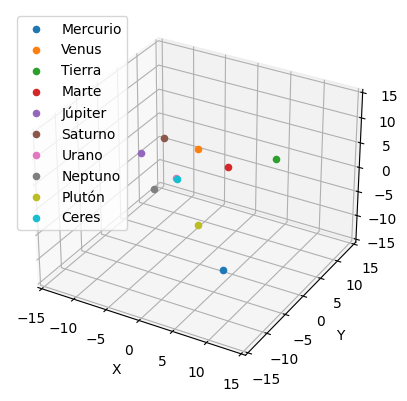

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Definir los nombres y características de los planetas
nombres = ['Mercurio', 'Venus', 'Tierra', 'Marte', 'Júpiter', 'Saturno', 'Urano', 'Neptuno', 'Plutón', 'Ceres']
caracteristicas = ['terrestre', 'terrestre', 'terrestre', 'terrestre', 'gaseoso', 'gaseoso', 'gaseoso', 'gaseoso', 'gaseoso', 'terrestre']

# Generar las coordenadas 3D aleatoriamente
x = np.random.uniform(-10, 10, 10)
y = np.random.uniform(-10, 10, 10)
z = np.random.uniform(-10, 10, 10)

# Crear el DataFrame
df = pd.DataFrame({
    'Planeta': nombres,
    'Característica': caracteristicas,
    'x': x,
    'y': y,
    'z': z
})

# Crear la figura y los ejes 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Configurar los límites de los ejes
ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])
ax.set_zlim([-15, 15])

# Agregar cada planeta a la figura
for i, row in df.iterrows():
    x, y, z = row['x'], row['y'], row['z']
    ax.scatter(x, y, z, label=row['Planeta'])

# Agregar leyenda y etiquetas de los ejes
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Mostrar la figura
plt.show()

In [46]:
import numpy as np
import pandas as pd

# Definir los nombres y características de los planetas
nombres = ['Mercurio', 'Venus', 'Tierra', 'Marte', 'Júpiter', 'Saturno', 'Urano', 'Neptuno', 'Plutón', 'Eris']
tipos = ['terrestre', 'terrestre', 'terrestre', 'terrestre', 'gaseoso', 'gaseoso', 'gaseoso', 'gaseoso', 'gaseoso', 'gaseoso']
coordenadas = np.random.rand(10, 3)

# Crear el pandas dataframe
planetas = pd.DataFrame({'nombre': nombres, 'tipo': tipos, 'x': coordenadas[:,0], 'y': coordenadas[:,1], 'z': coordenadas[:,2], 'expansiones': [0]*10, 'planetas_encontrados': [[] for i in range(10)]})

# Función para determinar si un planeta está dentro de un paralelepípedo
def dentro_paralelepipedo(x, y, z, x_centro, y_centro, z_centro, dx, dy, dz):
    return (x_centro - dx <= x <= x_centro + dx) and (y_centro - dy <= y <= y_centro + dy) and (z_centro - dz <= z <= z_centro + dz)

# Iterar sobre cada planeta
for i in range(len(planetas)):
    planeta_actual = planetas.iloc[i]
    tipo_actual = planeta_actual['tipo']
    x_centro, y_centro, z_centro = planeta_actual['x'], planeta_actual['y'], planeta_actual['z']
    dx, dy, dz = 1, 2, 1
    expansiones = 0
    planetas_encontrados = []
    
    # Encontrar los planetas dentro del paralelepípedo
    while len(planetas_encontrados) < 2 and expansiones < 10:
        for j in range(len(planetas)):
            if i != j:
                planeta_comparar = planetas.iloc[j]
                tipo_comparar = planeta_comparar['tipo']
                x, y, z = planeta_comparar['x'], planeta_comparar['y'], planeta_comparar['z']
                if tipo_actual == tipo_comparar and dentro_paralelepipedo(x, y, z, x_centro, y_centro, z_centro, dx, dy, dz):
                    planetas_encontrados.append(planeta_comparar['nombre'])
        if len(planetas_encontrados) < 2:
            dx *= 1.5
            dy *= 1.5
            dz *= 1.5
            expansiones += 1
    
    # Actualizar el pandas dataframe con los planetas encontrados y las expansiones necesarias
    planetas.at[i, 'expansiones'] = expansiones
    planetas.at[i, 'planetas_encontrados'] = planetas_encontrados

# Imprimir el pandas dataframe resultante
planetas

,nombre,tipo,x,y,z,expansiones,planetas_encontrados
0,Mercurio,terrestre,0.623447,0.113692,0.292409,0,"[Venus, Tierra, Marte]"
1,Venus,terrestre,0.687220,0.139147,0.118478,0,"[Mercurio, Tierra, Marte]"
2,Tierra,terrestre,0.176576,0.953609,0.704304,0,"[Mercurio, Venus, Marte]"
3,Marte,terrestre,0.355550,0.562291,0.129909,0,"[Mercurio, Venus, Tierra]"
4,Júpiter,gaseoso,0.157597,0.829653,0.024831,0,"[Saturno, Urano, Neptuno, Plutón, Eris]"
5,Saturno,gaseoso,0.805912,0.605099,0.045298,0,"[Júpiter, Urano, Neptuno, Plutón, Eris]"
6,Urano,gaseoso,0.323192,0.727396,0.338905,0,"[Júpiter, Saturno, Neptuno, Plutón, Eris]"
7,Neptuno,gaseoso,0.323119,0.006859,0.661481,0,"[Júpiter, Saturno, Urano, Plutón, Eris]"
8,Plutón,gaseoso,0.336420,0.018775,0.801933,0,"[Júpiter, Saturno, Urano, Neptuno, Eris]"
9,Eris,gaseoso,0.631130,0.768709,0.377616,0,"[Júpiter, Saturno, Urano, Neptuno, Plutón]"


In [ ]:


parametro_expansion=0.25
expansiones_max=12
expansiones_realizadas=0
round_hemi_accuracy=2

max_compositos_interiores=19  # ( restar 1 al numero objetivo)

freno_1_composito_x_roca=0  ###  SOLO LEER UN SOLO COMPOSITO POR COMBINACION ROCA/ZONA
freno_2_roca_x_zona=0  ###  SOLO LEER UNA SOLA ROCA POR ZONA
freno_3_zona=0    ### SOLO LEER UNICA ZONA

iterador=0      ##  PARA SIGNAR RATIO x ZONA

composito_counts=0

flag_holeid=df_parametros.Valor[15][0]

#for zone in df_parametros.Valor[12][:1]:     ## borrar   [:2]
zonas = df_parametros.Valor[12]
for zone in zonas:     #################################  FIJO PARA PRUEBA  BORRAR
    
    print("\n\n")
    print("zone:",zone)
    print(" ") 
    #  df_parametros.Valor[13]         ## LISTA DE AZIMUTH
    print("azimuth:",df_parametros.Valor[13][iterador])
    azimuth=df_parametros.Valor[13][iterador]
    cartesiana=0          ## <------ 

    if azimuth < 90:
        cartesiana=90-azimuth 
    elif azimuth < 180:
        cartesiana=360-(azimuth-90) 
    elif azimuth < 270:
        cartesiana=270-(azimuth-180) 
    elif azimuth < 360:
        cartesiana=180-(azimuth-270) 
        
    print("cartesiana:",cartesiana)
    rad=math.radians(cartesiana)    ## <------  APLICAR ACA SIN COS etc etc    
    print("radian:",rad)
    #df_parametros.Valor[14]                            ## LISTA DE ANISOTROPIA 
    print("ratio anisotropia:",df_parametros.Valor[14][iterador])

    ratio=df_parametros.Valor[14][iterador]
    hemi_axis_x, hemi_axis_y, hemi_axis_z = [], [], []
    for i in range(expansiones_max):       #  30*30*30       30*75*30
        # print((df_parametros.Valor[3][0] / 2)*((1+parametro_expansion)**i))
        # print(((df_parametros.Valor[3][1]*ratio) / 2)*((1+parametro_expansion)**i))
        # print((df_parametros.Valor[3][2] / 2)*((1+parametro_expansion)**i))
        # print((df_parametros.Valor[3][0] / 2)*((1+parametro_expansion)**i)*2)
        # print(((df_parametros.Valor[3][1]*ratio) / 2)*((1+parametro_expansion)**i)*2)
        # print((df_parametros.Valor[3][2] / 2)*((1+parametro_expansion)**i)*2)
        semi_x=(df_parametros.Valor[3][0] / 2)*((1+parametro_expansion)**i)
        semi_y=((df_parametros.Valor[3][1]*ratio) / 2)*((1+parametro_expansion)**i)
        semi_z=(df_parametros.Valor[3][2] / 2)*((1+parametro_expansion)**i)
        hemi_axis_x.append(round(semi_x,round_hemi_accuracy))
        hemi_axis_y.append(round(semi_y,round_hemi_accuracy))
        hemi_axis_z.append(round(semi_z,round_hemi_accuracy))

    ###for rock in df_parametros.Valor[8][:1]:## borrar   [3]
    rocks=df_parametros.Valor[8]
    for rock in rocks:

        freno_1_composito_x_roca=0

        print("\n\n\n")
        print("    rock:",rock)
        print("    zone:",zone)
        print(" ")
        print("    parametros de la Roca ")
        print("    ratio anisotropia:",ratio)
        print("    azimuth: ",azimuth)
        print("    cartesiana: ",cartesiana)
        print("    radian: ",rad)

        for obs in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T:  ## ITERAR INDICES

            composito_counts=composito_counts+1

            print("\n")
            print("        index composito :",obs)
            print(" ")
            x=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,1][obs]
            y=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,2][obs]
            z=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,3][obs]
             
            print("        x: ",x)
            print("        y: ",y)
            print("        z: ",z)
            obs_holeid=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs][7]
            print(" ")
            print("        holeid: ",obs_holeid)
            # x_SI,y_SI= x - semi_x,y + semi_y        
            # x_II,y_II= x - semi_x,y - semi_y
            # x_SD,y_SD= x + semi_x,y + semi_y
            # x_ID,y_ID= x + semi_x,y - semi_y      
            # print("        SI:",x_SI,y_SI)
            # print("        II:",x_II,y_II)  
            # print("        SD:",x_SD,y_SD) 
            # print("        ID:",x_ID,y_ID)
            # s = gpd.GeoSeries([Polygon([(x_II,y_II), (x_SI, y_SI), (x_SD, y_SD), (x_ID, y_ID)])])      
            ## RESPETAR ORDEN II SI SD ID
            #s[0]
            #s.rotate(cartesiana, origin=(x,y))[0]
            # rx,ry = s.rotate(  cartesiana, origin=(x,y))[0].exterior.coords.xy
            # coords = np.dstack((rx,ry)).tolist()
            #print(coords)           
            # print("        Rotated coords: ")
            # print("        ",coords[0][0][0],coords[0][0][1])
            # print("        ",coords[0][1][0],coords[0][1][1])
            # print("        ",coords[0][2][0],coords[0][2][1])
            # print("        ",coords[0][3][0],coords[0][3][1])
            # print("        ",coords[0][4][0],coords[0][4][1])
            # rotado2d=s.rotate(cartesiana, origin=(x,y))[0]
            # index_inner_3d=[]## INDICES EN POLIGONO ROTADO 3D  
            index_inner_3d=[]## INDICES EN POLIGONO ROTADO 3D
            ley=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,4][obs]
            print("        ley composito : ",ley)

            for i in range(expansiones_max):
                print(" ")
                print(" ")
                print("            expansion: ",i)
                print(" ")
                '''
                print("            semi eje x:",hemi_axis_x[i])
                print("            semi eje y:",hemi_axis_y[i])
                print("            semi eje z:",hemi_axis_z[i])
                '''

                x_SI,y_SI= x - hemi_axis_x[i] , y + hemi_axis_y[i]       
                x_II,y_II= x - hemi_axis_x[i] , y - hemi_axis_y[i]
                x_SD,y_SD= x + hemi_axis_x[i] , y + hemi_axis_y[i]
                x_ID,y_ID= x + hemi_axis_x[i] , y - hemi_axis_y[i]  

                '''
                print("            SI:  x: ",x_SI,"  y:",y_SI)
                print("            II:  x: ",x_II,"  y:",y_II)  
                print("            SD:  x: ",x_SD,"  y:",y_SD) 
                print("            ID:  x: ",x_ID,"  y:",y_ID)
                '''

                s = gpd.GeoSeries([Polygon([(x_II,y_II), (x_SI, y_SI), (x_SD, y_SD), (x_ID, y_ID)])])      
                # RESPETAR ORDEN II SI SD ID
                #s[0]
                #s.rotate(cartesiana, origin=(x,y))[0]
                #rx,ry = s.rotate(  cartesiana, origin=(x,y))[0].exterior.coords.xy
                rotado2d=s.rotate(cartesiana, origin=(x,y))[0]
                rx,ry = rotado2d.exterior.coords.xy
                coords = np.dstack((rx,ry)).tolist()
                '''
                print("            Rotated coords: ")
                print("            x: ",coords[0][0][0]," y: ",coords[0][0][1])
                print("            x: ",coords[0][1][0]," y: ",coords[0][1][1])
                print("            x: ",coords[0][2][0]," y: ",coords[0][2][1])
                print("            x: ",coords[0][3][0]," y: ",coords[0][3][1])
                print("            x: ",coords[0][4][0]," y: ",coords[0][4][1])
                '''


                for obs_sub in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T:

                    '''
                    print(" ")
                    print("                obs    : ",obs)
                    print("                obs_sub: ",obs_sub)
                    '''
                    sub_ley=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,4][obs_sub]
                    '''
                    print("                ley_sub: ",sub_ley)   
                    ''' 

                    x_int=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs_sub][1]
                    y_int=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs_sub][2]
                    '''
                    print("                x_sub: ",x_int)
                    print("                y_sub: ",y_int)
                    '''

                    composito_inter= gpd.GeoSeries([Point(x_int,y_int)])  ##  COMPONER coords del subcomposito

                    if rotado2d.intersects(composito_inter[0]) == True:
                        '''
                        print("                    SI 2D")
                        '''

                        z_int=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs_sub][3]
                        '''
                        print("                    z_sub: ",z_int)
                        print("                    z:     ",z)
                        '''
                        z_inner_diff=abs(z-z_int)
                        '''
                        print("                    dist z:",z_inner_diff)
                        print("                    dist max z:",hemi_axis_z[i])
                        '''

                        if z_inner_diff <= hemi_axis_z[i]:
                            '''
                            print("                        SI 3D")
                            '''
                            #index_inner_3d.append(obs_sub)
                            #print("                        index_inner_3d: ",index_inner_3d)

                            subobs_holeid=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs_sub][7]

                            '''
                            print("                        drillhole obs    : ",obs_holeid)
                            print("                        drillhole obs sub: ",subobs_holeid)
                            '''

                            if obs_sub not in index_inner_3d:
                                if flag_holeid==1:
                                    '''
                                    print("                            SI FLAG EXCLUIR SAME ID")
                                    '''
                                    if obs_holeid!=subobs_holeid:
                                        '''
                                        print("                            DISTINTO ID  -->  APPEND") 
                                        '''
                                        index_inner_3d.append(obs_sub)
                                else:
                                    index_inner_3d.append(obs_sub)

                    '''
                    else:
                        print("                    NO 2D") 
                    '''

                    if len(index_inner_3d) > max_compositos_interiores:       ####  ROMPER APENAS ENCUENTRE 20
                        break

                print("            ",index_inner_3d)
                print("            longitud index_inner:   ",len(index_inner_3d))
                #print("# expansion sub compositos:   ",i)
                ## NECESARIO ROMPER A ESTE NIVEL 
                if len(index_inner_3d) > max_compositos_interiores:   ###  ROMPER EXPANSION
                    print("# expansion break bucles expansivos:   ",i)
                    break   ###  ROMPER EXPANSION

                # if i > 8:   ###  ROMPER EXPANSION por numero de expansiones
                #     break   ###  ROMPER EXPANSION
            print(" ")
            print("verificar lista de busqueda...")
            print("longitud inder_inner fuera del bucle    ",len(index_inner_3d))
 
            print("indice composito en evaluacion -- NO SUB--   ",obs)
            index_inner_3d.append(obs)
            print("lista final de compositos SUB asociados a composito en evaluacion + composito en evaluacion")
            print(index_inner_3d)
            print("longitud final index  ",len(index_inner_3d))


            print(" ")
            print(" ")

            '''
            print("Dataframe solo inner index")
            print(df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[index_inner_3d])
            '''
            print("solo leyes")
            print(df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[index_inner_3d].iloc[[4]])
            print("\n")

            sub_df=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[index_inner_3d].iloc[[4]].T
            print("\n")        
            #print(sub_df)
            print("\n")

            sub_df["percent_ley"] = (sub_df.iloc[:,0] / sub_df.iloc[:,0].sum()) 
            print("\n")
            print(sub_df)
            print("\n")
            print("  Umbrales",df_parametros.Valor[5])
            print("\n")
            print("ley promedio")
            print(sub_df.iloc[:,0].mean())
            print("\n")
            print("relativo aportado por el composito ",sub_df.iloc[-1,1]*100,"%")  ## procentaje del composito
            print(" ")
            print(" ")      

            df_CLAG_MR_2022.iloc[obs,22]=len(index_inner_3d)
            df_CLAG_MR_2022.iloc[obs,20]=sub_df.iloc[:,0].mean()
            df_CLAG_MR_2022.iloc[obs,23]=i
            df_CLAG_MR_2022.iloc[obs,21]=sub_df.iloc[-1,1]
            df_CLAG_MR_2022.iloc[obs,24]=1                 #### DUMMY 

            '''
            df_CLAG_MR_2022["AvgSin_PY"]=0
            df_CLAG_MR_2022["AvgCon_PY"]=0           ##  PROMEDIO CON COMPOSITO
            df_CLAG_MR_2022["PROP_12_PY"]=0          ## PROPORCION APORTADA POR COMPOSITO   incluido composito
            df_CLAG_MR_2022["PROP_SIN_12_PY"]=0          ## PROPORCION APORTADA POR COMPOSITO         excluido composito 
            df_CLAG_MR_2022["Num_Data_PY"]=0
            df_CLAG_MR_2022["Num_EXPAN_PY"]=0          ## CANTIDAD DE EXPANSIONES GEENRADAS EN ESE COMPOSITO
            df_CLAG_MR_2022["EVALUADO_PY"]=0       ## DUMMY  1= SI ENTRO A CALCULO PYTHON
            df_CLAG_MR_2022["List_LEY_PY"]=0          ## LEY DE CADA COMPOSITO QUE INTERVIENE 21
            df_CLAG_MR_2022["List_INDEX_PY"]=0                ## INDICES DE COMPOSITOS 21
            df_CLAG_MR_2022["List_COUNT_INDEX_PY"]=0         ## INDICE COMPOSITO
            df_CLAG_MR_2022["List_INDEX_BUBBLE_PY"]=0         ## INDICE TODOS LOS COMPOSITOS     NO  top 21  -  TODOS          LISTA
            df_CLAG_MR_2022["TIME_PY"]=0  
            '''

            print("pre_bucle")
            
            ley_sin=sub_df.iloc[:-1,1].mean()      ### promedio SIN composito central
            ley_con=sub_df.iloc[:,1].mean()        ### promedio CON composito central
            variax=abs((ley_con/ley_sin)-1)

            if variax > df_parametros.Valor[5][0]:
                print("T1")
                print(df_parametros.Valor[5][0])
                df_CLAG_MR_2022.iloc[obs,8]=ley-(sub_df.iloc[:,0].mean()*df_parametros.Valor[5][0])
                df_CLAG_MR_2022.iloc[obs,9]=1             
                if variax > df_parametros.Valor[5][1]:
                    print("T2")
                    print(df_parametros.Valor[5][1])
                    df_CLAG_MR_2022.iloc[obs,10]=ley-(sub_df.iloc[:,0].mean()*df_parametros.Valor[5][1])
                    df_CLAG_MR_2022.iloc[obs,11]=1         
                    if variax> df_parametros.Valor[5][2]:
                        print("T3")
                        print(df_parametros.Valor[5][2])
                        df_CLAG_MR_2022.iloc[obs,12]=ley-(sub_df.iloc[:,0].mean()*df_parametros.Valor[5][2])
                        df_CLAG_MR_2022.iloc[obs,13]=1
                        if variax > df_parametros.Valor[5][3]:
                            print("T4")
                            print(df_parametros.Valor[5][3])
                            df_CLAG_MR_2022.iloc[obs,14]=ley-(sub_df.iloc[:,0].mean()*df_parametros.Valor[5][3])
                            df_CLAG_MR_2022.iloc[obs,15]=1
                            if variax > df_parametros.Valor[5][4]:
                                print("T5")
                                print(df_parametros.Valor[5][4])
                                df_CLAG_MR_2022.iloc[obs,16]=ley-(sub_df.iloc[:,0].mean()*df_parametros.Valor[5][4])
                                df_CLAG_MR_2022.iloc[obs,17]=1
                                if variax > df_parametros.Valor[5][5]:
                                    print("T6")
                                    print(df_parametros.Valor[5][5])
                                    df_CLAG_MR_2022.iloc[obs,18]=ley-(sub_df.iloc[:,0].mean()*df_parametros.Valor[5][5])
                                    df_CLAG_MR_2022.iloc[obs,19]=1               
            else:
                print("NO EN UMBRAL MINIMO")


            
            freno_1_composito_x_roca=freno_1_composito_x_roca+1
            if freno_1_composito_x_roca>0:
                break
        freno_2_roca_x_zona=freno_2_roca_x_zona+1
        if freno_2_roca_x_zona>0:
            break
    freno_3_zona=freno_3_zona+1
    if freno_3_zona>0:
        break
    iterador=iterador+1


    print(" ")
    print(" ")



#df_CLAG_MR_2022.to_csv("Local_ag_martes_test.csv")


In [25]:

parametro_expansion=0.25
expansiones_max=12
expansiones_realizadas=0
round_hemi_accuracy=2

max_compositos_interiores=19  # ( restar 1 al numero objetivo)

freno_1_composito_x_roca=0  ###  SOLO LEER UN SOLO COMPOSITO POR COMBINACION ROCA/ZONA
freno_2_roca_x_zona=0  ###  SOLO LEER UNA SOLA ROCA POR ZONA
freno_3_zona=0    ### SOLO LEER UNICA ZONA

iterador=0      ##  PARA SIGNAR RATIO x ZONA

composito_counts=0

flag_holeid=df_parametros.Valor[15][0]

#for zone in df_parametros.Valor[12][:1]:     ## borrar   [:2]
zonas = df_parametros.Valor[12]
for zone in zonas:     #################################  FIJO PARA PRUEBA  BORRAR
    
    print("\n\n")
    print("zone:",zone)
    print(" ") 
    #  df_parametros.Valor[13]         ## LISTA DE AZIMUTH
    print("azimuth:",df_parametros.Valor[13][iterador])
    azimuth=df_parametros.Valor[13][iterador]
    cartesiana=0          ## <------ 

    if azimuth < 90:
        cartesiana=90-azimuth 
    elif azimuth < 180:
        cartesiana=360-(azimuth-90) 
    elif azimuth < 270:
        cartesiana=270-(azimuth-180) 
    elif azimuth < 360:
        cartesiana=180-(azimuth-270) 
        
    print("cartesiana:",cartesiana)
    rad=math.radians(cartesiana)    ## <------  APLICAR ACA SIN COS etc etc    
    print("radian:",rad)
    #df_parametros.Valor[14]                            ## LISTA DE ANISOTROPIA 
    print("ratio anisotropia:",df_parametros.Valor[14][iterador])

    ratio=df_parametros.Valor[14][iterador]
    hemi_axis_x, hemi_axis_y, hemi_axis_z = [], [], []
    for i in range(expansiones_max):       #  30*30*30       30*75*30
        # print((df_parametros.Valor[3][0] / 2)*((1+parametro_expansion)**i))
        # print(((df_parametros.Valor[3][1]*ratio) / 2)*((1+parametro_expansion)**i))
        # print((df_parametros.Valor[3][2] / 2)*((1+parametro_expansion)**i))
        # print((df_parametros.Valor[3][0] / 2)*((1+parametro_expansion)**i)*2)
        # print(((df_parametros.Valor[3][1]*ratio) / 2)*((1+parametro_expansion)**i)*2)
        # print((df_parametros.Valor[3][2] / 2)*((1+parametro_expansion)**i)*2)
        semi_x=(df_parametros.Valor[3][0] / 2)*((1+parametro_expansion)**i)
        semi_y=((df_parametros.Valor[3][1]*ratio) / 2)*((1+parametro_expansion)**i)
        semi_z=(df_parametros.Valor[3][2] / 2)*((1+parametro_expansion)**i)
        hemi_axis_x.append(round(semi_x,round_hemi_accuracy))
        hemi_axis_y.append(round(semi_y,round_hemi_accuracy))
        hemi_axis_z.append(round(semi_z,round_hemi_accuracy))

    ###for rock in df_parametros.Valor[8][:1]:## borrar   [3]
    rocks=df_parametros.Valor[8]
    for rock in rocks:

        freno_1_composito_x_roca=0

        print("\n\n\n")
        print("    rock:",rock)
        print("    zone:",zone)
        print(" ")
        print("    parametros de la Roca ")
        print("    ratio anisotropia:",ratio)
        print("    azimuth: ",azimuth)
        print("    cartesiana: ",cartesiana)
        print("    radian: ",rad)

        for obs in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T:  ## ITERAR INDICES

            composito_counts=composito_counts+1

            # print("\n")
            print("        index composito :",obs)
            print(" ")
            # x=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,1][obs]
            # y=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,2][obs]
            # z=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,3][obs]
             
            # print("        x: ",x)
            # print("        y: ",y)
            # print("        z: ",z)

            obs_holeid=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs][7]
            print(" ")
            print("        holeid: ",obs_holeid)

            X_obs_holeid=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs][7]
            print(" ")
            print("        holeid: ",X_obs_holeid)


 
            ley=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].iloc[:,4][obs]
            print("        ley composito : ",ley)

            

            freno_1_composito_x_roca=freno_1_composito_x_roca+1
            if freno_1_composito_x_roca>1000:
                break
        freno_2_roca_x_zona=freno_2_roca_x_zona+1
        if freno_2_roca_x_zona>0:
            break
    freno_3_zona=freno_3_zona+1
    if freno_3_zona>0:
        break
    iterador=iterador+1


print("\n\n\n",composito_counts)




zone: 41
 
azimuth: 140
cartesiana: 310
radian: 5.410520681182422
ratio anisotropia: 2.5




    rock: 31
    zone: 41
 
    parametros de la Roca 
    ratio anisotropia: 2.5
    azimuth:  140
    cartesiana:  310
    radian:  5.410520681182422
        index composito : 73
 
 
        holeid:  A055
        index composito : 74
 
 
        holeid:  A055
        index composito : 75
 
 
        holeid:  A055
        index composito : 76
 
 
        holeid:  A055
        index composito : 77
 
 
        holeid:  A055
        index composito : 116
 
 
        holeid:  A062
        index composito : 117
 
 
        holeid:  A062
        index composito : 118
 
 
        holeid:  A062
        index composito : 119
 
 
        holeid:  A062
        index composito : 120
 
 
        holeid:  A062
        index composito : 121
 
 
        holeid:  A062
        index composito : 151
 
 
        holeid:  A070
        index composito : 152
 
 
        holeid:  A070
        index composito : 153

In [ ]:
for obs in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T:  ## ITERAR INDICES
    composito_counts=composito_counts+1
    print("        index composito :",obs)

In [ ]:
for obs in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T:  ## ITERAR INDICES
    composito_counts=composito_counts+1
    print("        index composito :",obs)

In [36]:
for i in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].index:
#for i in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T:

    print(i)

73
74
75
76
77
116
117
118
119
120
121
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
204
205
206
207
208
209
210
211
212
213
214
215
216
217
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
368
369
370
371
372
373
374
375
376
377
378
384
387
391
392
393
397
400
402
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
503
504
505
506
507
508
509
510
511
512
513
514
515
613
614
615
616
620
621
622
623
650
651
653
654
655
656
665
666
668
669
670
671
672
673
674
678
679
680
681
682
683
684
685
686
716
717
718
719
720
721
722
723
724
725
728
729
730
731
732
733
734
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
8

In [35]:

for i in df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T:
    print(i)


73
74
75
76
77
116
117
118
119
120
121
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
204
205
206
207
208
209
210
211
212
213
214
215
216
217
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
368
369
370
371
372
373
374
375
376
377
378
384
387
391
392
393
397
400
402
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
503
504
505
506
507
508
509
510
511
512
513
514
515
613
614
615
616
620
621
622
623
650
651
653
654
655
656
665
666
668
669
670
671
672
673
674
678
679
680
681
682
683
684
685
686
716
717
718
719
720
721
722
723
724
725
728
729
730
731
732
733
734
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
8

In [59]:
df_zona_roca_local

,COUNT,mid_x,mid_y,mid_z,Ag_ppm_BESTEL,NBKRT,AG_SUBZONAS,HOLEID,CAPVAL1_PY,CAPPED1_PY,CAPVAL2_PY,CAPPED2_PY,CAPVAL3_PY,CAPPED3_PY,CAPVAL4_PY,CAPPED4_PY,CAPVAL5_PY,CAPPED5_PY,CAPVAL6_PY,CAPPED6_PY,AvgSin_PY,AvgCon_PY,PROP_12_PY,PROP_SIN_12_PY,Num_Data_PY,Num_EXPAN_PY,EVALUADO_PY,List_LEY_PY,List_INDEX_PY,List_COUNT_INDEX_PY,List_INDEX_BUBBLE_PY,TIME_PY
73,6586,3185.3567,4329.8712,4116.0064,0.828571,31,41,A055,0.828571,0,0.828571,0,0.828571,0,0.828571,0,0.828571,0,0.828571,0,14.745175,0.002676,21,8,1,0,0,0,0,0,0,0
74,6587,3187.2542,4327.8264,4113.6524,2.000000,31,41,A055,2.000000,0,2.000000,0,2.000000,0,2.000000,0,2.000000,0,2.000000,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0
75,6588,3188.8393,4326.1182,4111.6847,10.200000,31,41,A055,10.200000,0,10.200000,0,10.200000,0,10.200000,0,10.200000,0,10.200000,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0
76,6589,3190.3981,4324.4384,4109.7487,7.300000,31,41,A055,7.300000,0,7.300000,0,7.300000,0,7.300000,0,7.300000,0,7.300000,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0
77,6590,3191.7748,4322.9548,4108.0381,35.708694,31,41,A055,35.708694,0,35.708694,0,35.708694,0,35.708694,0,35.708694,0,35.708694,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,386872,3625.0799,4814.7813,4040.8409,74.000000,31,41,A858,74.000000,0,74.000000,0,74.000000,0,74.000000,0,74.000000,0,74.000000,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0
4234,386873,3626.3318,4813.6183,4038.3751,35.000000,31,41,A858,35.000000,0,35.000000,0,35.000000,0,35.000000,0,35.000000,0,35.000000,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0
4235,386874,3627.5846,4812.4561,4035.9094,17.799999,31,41,A858,17.799999,0,17.799999,0,17.799999,0,17.799999,0,17.799999,0,17.799999,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0
4236,386875,3628.8383,4811.2949,4033.4436,13.000000,31,41,A858,13.000000,0,13.000000,0,13.000000,0,13.000000,0,13.000000,0,13.000000,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0


In [77]:
obs_holeid=df_CLAG_MR_2022[(df_CLAG_MR_2022.iloc[:, 5] == rock) & (df_CLAG_MR_2022.iloc[:, 6] == zone)].T[obs][7]
print(" ")
print("        holeid: ",obs_holeid)





 
        holeid:  A055


In [78]:
X_obs_holeid=df_zona_roca_local.T[obs][7]
print(" ")
print("        holeid: ",X_obs_holeid)

 
        holeid:  A055


In [79]:
X_obs_holeid=df_zona_roca_local.iloc[obs,7]
print(" ")
print("        holeid: ",X_obs_holeid)

 
        holeid:  A1015


In [75]:
df_zona_roca_local.iloc[obs]

COUNT                       13058
mid_x                   3705.1734
mid_y                   4835.3377
mid_z                    4188.079
Ag_ppm_BESTEL           45.349998
NBKRT                          31
AG_SUBZONAS                    41
HOLEID                      A1015
CAPVAL1_PY              45.349998
CAPPED1_PY                      0
CAPVAL2_PY              45.349998
CAPPED2_PY                      0
CAPVAL3_PY              45.349998
CAPPED3_PY                      0
CAPVAL4_PY              45.349998
CAPPED4_PY                      0
CAPVAL5_PY              45.349998
CAPPED5_PY                      0
CAPVAL6_PY              45.349998
CAPPED6_PY                      0
AvgSin_PY                     0.0
AvgCon_PY                     0.0
PROP_12_PY                      0
PROP_SIN_12_PY                  0
Num_Data_PY                     0
Num_EXPAN_PY                    0
EVALUADO_PY                     0
List_LEY_PY                     0
List_INDEX_PY                   0
List_COUNT_IND

In [76]:
df_zona_roca_local.T[obs]

COUNT                       13058
mid_x                   3185.3567
mid_y                   4329.8712
mid_z                   4116.0064
Ag_ppm_BESTEL            0.828571
NBKRT                          31
AG_SUBZONAS                    41
HOLEID                       A055
CAPVAL1_PY               0.828571
CAPPED1_PY                      0
CAPVAL2_PY               0.828571
CAPPED2_PY                      0
CAPVAL3_PY               0.828571
CAPPED3_PY                      0
CAPVAL4_PY               0.828571
CAPPED4_PY                      0
CAPVAL5_PY               0.828571
CAPPED5_PY                      0
CAPVAL6_PY               0.828571
CAPPED6_PY                      0
AvgSin_PY               14.745175
AvgCon_PY                0.002676
PROP_12_PY                     21
PROP_SIN_12_PY                  8
Num_Data_PY                     1
Num_EXPAN_PY                    0
EVALUADO_PY                     0
List_LEY_PY                     0
List_INDEX_PY                   0
List_COUNT_IND

In [71]:
df_zona_roca_local.COUNT=13058

C:\Users\LZ8952\AppData\Local\Temp\ipykernel_24308\45744219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zona_roca_local.COUNT=13058


In [98]:
for index, row in df_zona_roca_local.iterrows():
    print(index)
    print(row[3])
    value = row['COUNT']
    print(value)
    value2=row['mid_x']
    print(value2)
    print(" ")


73
4116.0064
6586
3185.3567
 
74
4113.6524
6587
3187.2542
 
75
4111.6847
6588
3188.8393
 
76
4109.7487
6589
3190.3981
 
77
4108.0381
6590
3191.7748
 
116
4199.8413
7164
3822.7913
 
117
4177.6951
7173
3833.4343
 
118
4175.2496
7174
3834.6317
 
119
4172.8071
7175
3835.8321
 
120
4170.3678
7176
3837.0355
 
121
4167.9315
7177
3838.2419
 
151
4130.86
8060
3580.88
 
152
4127.86
8061
3580.88
 
153
4124.86
8062
3580.88
 
154
4121.86
8063
3580.88
 
155
4118.86
8064
3580.88
 
156
4115.86
8065
3580.88
 
157
4112.86
8066
3580.88
 
158
4109.86
8067
3580.88
 
159
4106.86
8068
3580.88
 
160
4103.86
8069
3580.88
 
161
4100.86
8070
3580.88
 
162
4097.86
8071
3580.88
 
163
4094.86
8072
3580.88
 
164
4091.86
8073
3580.88
 
165
4088.86
8074
3580.88
 
166
4085.86
8075
3580.88
 
167
4082.86
8076
3580.88
 
168
4079.86
8077
3580.88
 
169
4076.86
8078
3580.88
 
170
4073.86
8079
3580.88
 
171
4070.86
8080
3580.88
 
172
4067.86
8081
3580.88
 
173
4065.41
8082
3580.88
 
174
4059.96
8084
3580.88
 
175
4056.96
8085

In [22]:
############
# ITERACION   DF
c=0
for i in df_CLAG_MR_2022.COUNT:
    print(i)
    c=c+1
c    

2336
2337
2338
2339
2340
2341
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2865
2866
2867
3751
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
6459
6460
6461
6462
6463
6464
6472
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6583
6584
6585
6586
6587
6588
6589
6590
6591
6592
6593
6594
6595
6596
6597
6598
6599
6600
6601
6602
6603
6604
6605
6606
6607
6608
6609
6610
6611
6612
6613
6614
6615
6616
6617
6618
6622
6623
6624
6625
6626
6627
7047
7048
7049
7052
7164
7173
7174
7175
7176
7177
7195
7196
7197
7198
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7663
7664
7665
7760
7761
7762
7765
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8100
8101
8102
8103
8104
8211
8223
9335
9336
9337
9338


4255

0         2336
1         2337
2         2338
3         2339
4         2340
         ...  
4250    390969
4251    390970
4252    390971
4253    394849
4254    394850
Name: COUNT, Length: 4255, dtype: int64

In [32]:
df_CLAG_MR_2022[df_CLAG_MR_2022.COUNT]

KeyError: "None of [Int64Index([390969, 390969, 390969, 390969, 390969, 390969, 390969, 390969,\n            390969, 390969,\n            ...\n            390969, 390969, 390969, 390969, 390969, 390969, 390969, 390969,\n            390969, 390969],\n           dtype='int64', length=4255)] are in the [columns]"

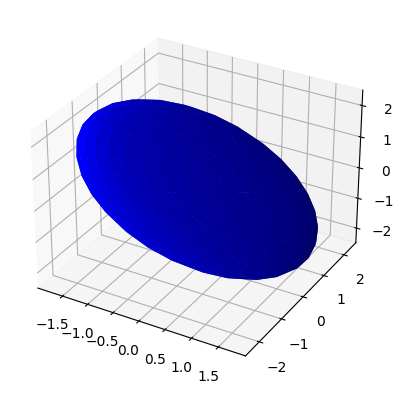

In [33]:
### ELIPSE_

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Definir los parámetros de la elipsoide
center = [0, 0, 0]
a, b, c = 3, 2, 1

# Crear una malla de puntos para la elipsoide
u = np.linspace(0, 2 * np.pi, 30)
v = np.linspace(0, np.pi, 20)
x = a * np.outer(np.cos(u), np.sin(v))
y = b * np.outer(np.sin(u), np.sin(v))
z = c * np.outer(np.ones_like(u), np.cos(v))

# Rotar y trasladar la elipsoide
theta, phi, gamma = np.pi/4, np.pi/4, np.pi/4
rot = np.array([[np.cos(theta) * np.cos(phi), np.cos(theta) * np.sin(phi), -np.sin(theta)],
                [np.sin(gamma) * np.sin(theta) * np.cos(phi) - np.cos(gamma) * np.sin(phi), np.sin(gamma) * np.sin(theta) * np.sin(phi) + np.cos(gamma) * np.cos(phi), np.sin(gamma) * np.cos(theta)],
                [np.cos(gamma) * np.sin(theta) * np.cos(phi) + np.sin(gamma) * np.sin(phi), np.cos(gamma) * np.sin(theta) * np.sin(phi) - np.sin(gamma) * np.cos(phi), np.cos(gamma) * np.cos(theta)]])
points = np.vstack((x.flatten(), y.flatten(), z.flatten())).T
points = np.dot(points - center, rot) + center
x = points[:, 0].reshape(x.shape)
y = points[:, 1].reshape(y.shape)
z = points[:, 2].reshape(z.shape)

# Crear la figura y la gráfica en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, color='b')

# Mostrar la figura
plt.show()